In [ ]:
import scipy as sp
import numpy as np
import numpy.random as rd
import scipy.linalg as LA
import scipy.sparse.linalg as sLA

#%matplotlib notebook     #INTERACTIVE PLOTS
#%matplotlib qt # wx, gtk, osx, tk           #INTERACTIVE PLOTS

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import seaborn as sns
sns.set(style='whitegrid')

In [ ]:
from RMG import RMG

In [ ]:
def lambda_funct (evlA,evlB,T):
    tt = np.all(evlA==0) or np.all(evlB==0)
    if T!=0:
        return evlA+sp.special.lambertw(evlB*T*np.exp(-evlA*T))/T
    elif T==0 and tt:
        return (evlA+evlB)
    
def poly_funct (evlA,evlB,lamb):
    dd = (evlA-lamb)/2
    ss = np.sqrt( dd**2 + (evlB + evlA)*lamb )
    return  dd+ss, dd-ss 

In [15]:
#EIGENVALUES COMPUTATION
def comp_eig(M, sparse='no',symm='no'):
    evl=0
    if symm == 'no':
        if sparse =='no':
            evl = LA.eigvals(M)
        if sparse =='yes':
            mm = sp.sparse.csr_matrix(M)
            evl = sLA.eigs(mm,k=1,which='LR',return_eigenvectors=False)
    if symm == 'yes':
        if sparse =='no':
            evl = LA.eigvalsh(M)
        if sparse =='yes':
            mm = sp.sparse.csr_matrix(M)
            evl = sLA.eigsh(mm,k=1,which='LA',return_eigenvectors=False)
    return evl

def comp_eig_delay(A, B, lamb, symm='no'):
    if np.all(A == 0):
        evlB = comp_eig(B, sparse='no',symm=symm)
        return poly_funct (0,evlB,lamb)
    elif np.all(B == 0):
        evlA = comp_eig(A, sparse='no',symm=symm)
        return poly_funct (evlA,0,lamb)
    else:
        evlA = comp_eig(A, sparse='no',symm=symm)
        evlB = comp_eig(B, sparse='no',symm=symm)
        return poly_funct (evlA,evlB,lamb)
    
def eig_double (A,B,lamb,symm='no',which='a'):
    if which=='a':
        evlA, evec = LA.eig(A)
        rho = np.sum(evec*(B@evec), axis=0)/np.sum((evec*evec), axis=0)
        return poly_funct (evlA,rho,lamb)
    if which=='b':
        evlB, evec = LA.eig(B)
        rho = np.sum(evec*(A@evec), axis=0)/np.sum((evec*evec), axis=0)
        return poly_funct (rho,evlB,lamb)

In [16]:
color = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']

# Generic Linear DDE with distributed delay

We consider the ordinary linear differential equation with distributed delay:

$$\dfrac{d\vec{x}}{dt} = \ A\cdot\vec{x}(t)\ +\ B\cdot\int_0^\infty \lambda_0 e^{-\lambda_0 T}\vec{x}(t-T)dT$$

Here A and B are the Jacobian matrices, we can substitute them with Random Matrices and then study the system using the Random Matrix Theory.

The eigenvalues of the system can be computed using the Linear Stability Analysis with a solution $\vec{x}(t) = e^{\lambda t}\vec{v}$ obtaining:

$$\lambda\vec{v}\ =\ A\cdot\vec{v}\ +\ \dfrac{\lambda_0}{\lambda_0+\lambda} B\cdot\vec{v}$$

If $\quad[A,B] = 0\quad$ with $\quad a=eig(A),\ b=eig(B)\quad$ then we get the characteristic equation with solutions:

$$\lambda - a - \dfrac{b\lambda_0}{\lambda_0+\lambda} = 0 \qquad\rightarrow\qquad \lambda = \dfrac{a-\lambda_0}{2} \pm \sqrt{\dfrac{(a-\lambda_0)^2}{4} +\lambda_0(a+b)}$$

## Case $A=0$ (only delay)

In [20]:
S = 1000       #species - shape matrix
C = 0.4        #connectance
d = 1          #diagonal elements
mu = 0         #mean random coefficients
sigma = 0.05    #sigma random coefficients

complexity = sigma*np.sqrt(S*C)
Class = RMG(S,C,d,mu,sigma)

In [21]:
#circle
theta = np.linspace(0, 2*np.pi, 4000)
r = complexity
x = r*np.cos(theta)
y = r*np.sin(theta)
#ellipse
E = np.sqrt(2/np.pi)*sigma
a = complexity*(1+(E/sigma)**2)
b = complexity*(1-(E/sigma)**2)
c = np.sqrt(a**2-b**2)
r1 = b/np.sqrt(1-(c/a*np.cos(theta))**2)
x1 = r1*np.cos(theta)
y1 = r1*np.sin(theta)

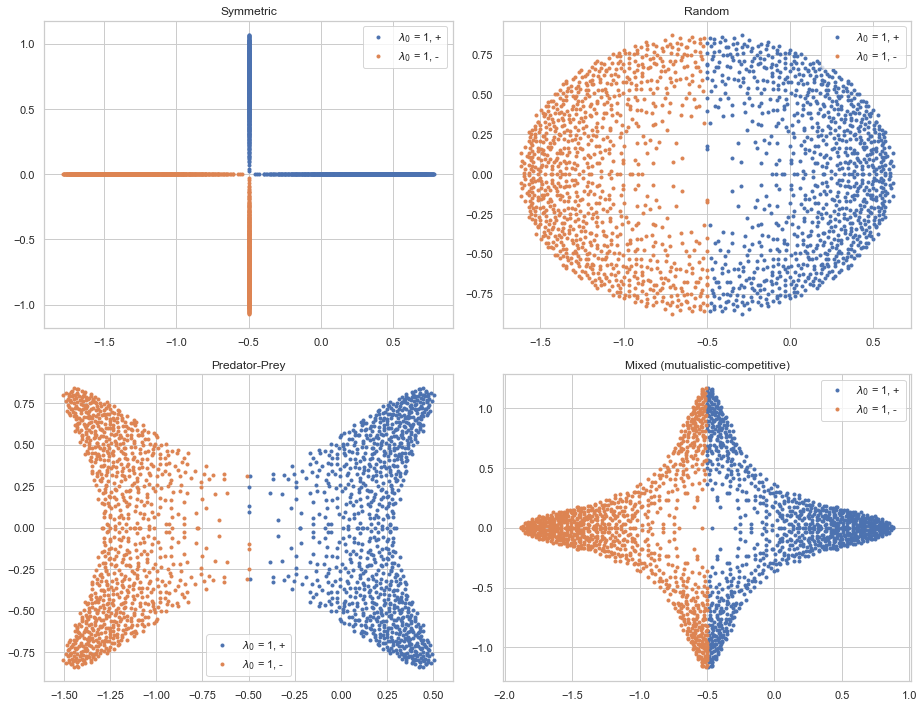

In [22]:
Class.d = 0
lamb = [1]

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(13,10)

plt.subplot(2,2,1)
Class.sym_matrix()
for ll in lamb:
    evl1, evl2  = comp_eig_delay(0,Class.M,ll)
    plt.plot(evl1.real, evl1.imag,'.',label=f'$\lambda_0$ = {ll}, +')
    plt.plot(evl2.real, evl2.imag,'.',label=f'$\lambda_0$ = {ll}, -')
plt.title("Symmetric")
plt.legend()

plt.subplot(2,2,2)
Class.ran_matrix()
for ll in lamb:
    evl1, evl2  = comp_eig_delay(0,Class.M,ll)
    plt.plot(evl1.real, evl1.imag,'.',label=f'$\lambda_0$ = {ll}, +')
    plt.plot(evl2.real, evl2.imag,'.',label=f'$\lambda_0$ = {ll}, -')
plt.title("Random")
plt.legend()

plt.subplot(2,2,3)
Class.pp_matrix()
for ll in lamb:
    evl1, evl2  = comp_eig_delay(0,Class.M,ll)
    plt.plot(evl1.real, evl1.imag,'.',label=f'$\lambda_0$ = {ll}, +')
    plt.plot(evl2.real, evl2.imag,'.',label=f'$\lambda_0$ = {ll}, -')
plt.title("Predator-Prey")
plt.legend()

plt.subplot(2,2,4)
Class.mix_matrix()
for ll in lamb:
    evl1, evl2  = comp_eig_delay(0,Class.M,ll)
    plt.plot(evl1.real, evl1.imag,'.',label=f'$\lambda_0$ = {ll}, +')
    plt.plot(evl2.real, evl2.imag,'.',label=f'$\lambda_0$ = {ll}, -')
plt.title("Mixed (mutualistic-competitive)")
plt.legend()

fig.tight_layout()
plt.show(fig)

### Center in the origin (d=0)

In [ ]:
#test1, test2 = poly_funct(0,complexity+1.j*0,ll)
#plt.plot(test1.real,test1.imag,'ko')
#plt.plot(test2.real,test2.imag,'ro')

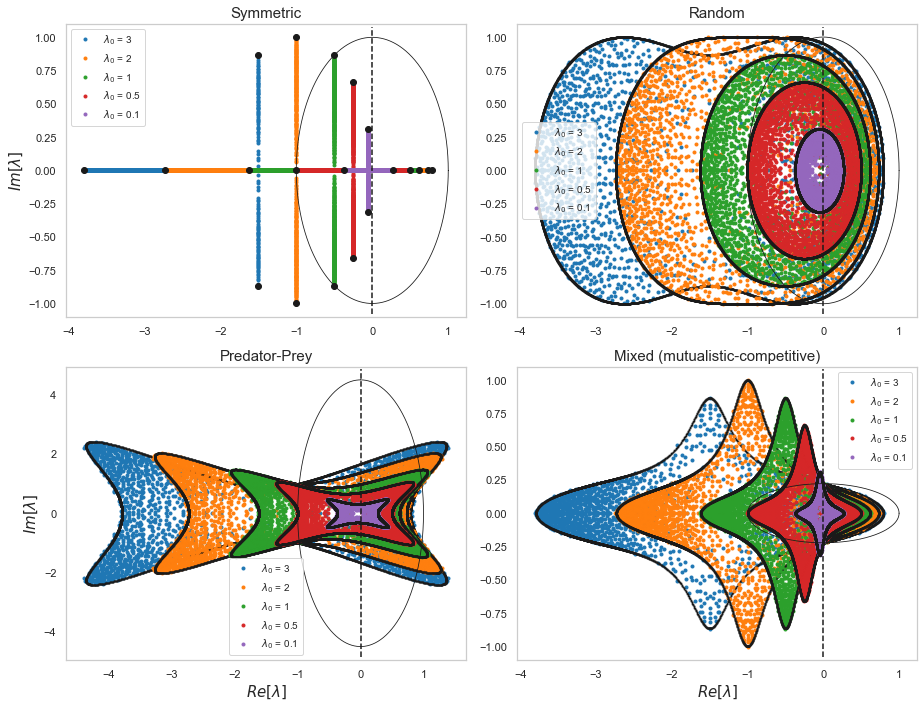

In [23]:
Class.d = 0
lamb = [3,2,1,0.5,0.1]
num=0

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(13,10)

plt.subplot(2,2,1)
Class.sigma = sigma/np.sqrt(2)
Class.sym_matrix()
for j,ll in enumerate(lamb):
    evl1, evl2  = comp_eig_delay(0,Class.M,ll)
    plt.plot(evl1.real, evl1.imag,'.',color=color[j],label=f'$\lambda_0$ = {ll}')
    plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    for k in range(num):
        Class.sym_matrix()
        evl1, evl2  = comp_eig_delay(0,Class.M,ll)
        plt.plot(evl1.real, evl1.imag,'.',color=color[j])
        plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    f1, f2 = poly_funct (0,np.array([-Class.d-complexity,-Class.d+complexity],dtype=complex),ll)
    plt.plot(f1.real,f1.imag,'ko')
    plt.plot(f2.real,f2.imag,'ko')
#plt.plot(-Class.d,0,'or')
plt.plot(x-Class.d,y,'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Symmetric",fontsize=15)
plt.legend(fontsize=10)

plt.subplot(2,2,2)
Class.sigma = sigma
Class.ran_matrix()
for j,ll in enumerate(lamb):
    evl1, evl2  = comp_eig_delay(0,Class.M,ll)
    plt.plot(evl1.real, evl1.imag,'.',color=color[j],label=f'$\lambda_0$ = {ll}')
    plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    for k in range(num):
        Class.ran_matrix()
        evl1, evl2  = comp_eig_delay(0,Class.M,ll)
        plt.plot(evl1.real, evl1.imag,'.',color=color[j])
        plt.plot(evl2.real, evl2.imag,'.',color=color[j])  
    f1, f2 = poly_funct (0,x-Class.d+1.j*y,ll)
    plt.plot(f1.real,f1.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
    plt.plot(f2.real,f2.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
#plt.plot(-Class.d,0,'or')
plt.plot(x-Class.d,y,'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random",fontsize=15)
plt.legend(fontsize=10)

plt.subplot(2,2,3)
Class.sigma = sigma*(np.pi/(np.pi-2))
Class.pp_matrix()
for j,ll in enumerate(lamb):
    evl1, evl2  = comp_eig_delay(0,Class.M,ll)
    plt.plot(evl1.real, evl1.imag,'.',color=color[j],label=f'$\lambda_0$ = {ll}')
    plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    for k in range(num):
        Class.pp_matrix()
        evl1, evl2  = comp_eig_delay(0,Class.M,ll)
        plt.plot(evl1.real, evl1.imag,'.',color=color[j])
        plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    f1, f2 = poly_funct (0,y1*(np.pi/(np.pi-2))-Class.d+1.j*x1*(np.pi/(np.pi-2)),ll)
    plt.plot(f1.real,f1.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
    plt.plot(f2.real,f2.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
#plt.plot(-Class.d,0,'or')
plt.plot(y1*(np.pi/(np.pi-2))-Class.d,x1*(np.pi/(np.pi-2)),'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Predator-Prey",fontsize=15)
plt.legend(fontsize=10)

plt.subplot(2,2,4)
Class.sigma = sigma*np.pi/(np.pi+2)
Class.mix_matrix()
for j,ll in enumerate(lamb):
    evl1, evl2  = comp_eig_delay(0,Class.M,ll)
    plt.plot(evl1.real, evl1.imag,'.',color=color[j],label=f'$\lambda_0$ = {ll}')
    plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    for k in range(num):
        Class.mix_matrix()
        evl1, evl2  = comp_eig_delay(0,Class.M,ll)
        plt.plot(evl1.real, evl1.imag,'.',color=color[j])
        plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    f1, f2 = poly_funct (0,x1*(np.pi/(np.pi+2))-Class.d+1.j*y1*(np.pi/(np.pi+2)),ll)
    plt.plot(f1.real,f1.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
    plt.plot(f2.real,f2.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
#plt.plot(-Class.d,0,'or')
plt.plot(x1*(np.pi/(np.pi+2))-Class.d,y1*(np.pi/(np.pi+2)),'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.title("Mixed (mutualistic-competitive)",fontsize=15)
plt.legend(fontsize=10)

fig.tight_layout()
plt.show(fig)

### Center in $\ (-1,0)\ $ (d=1)

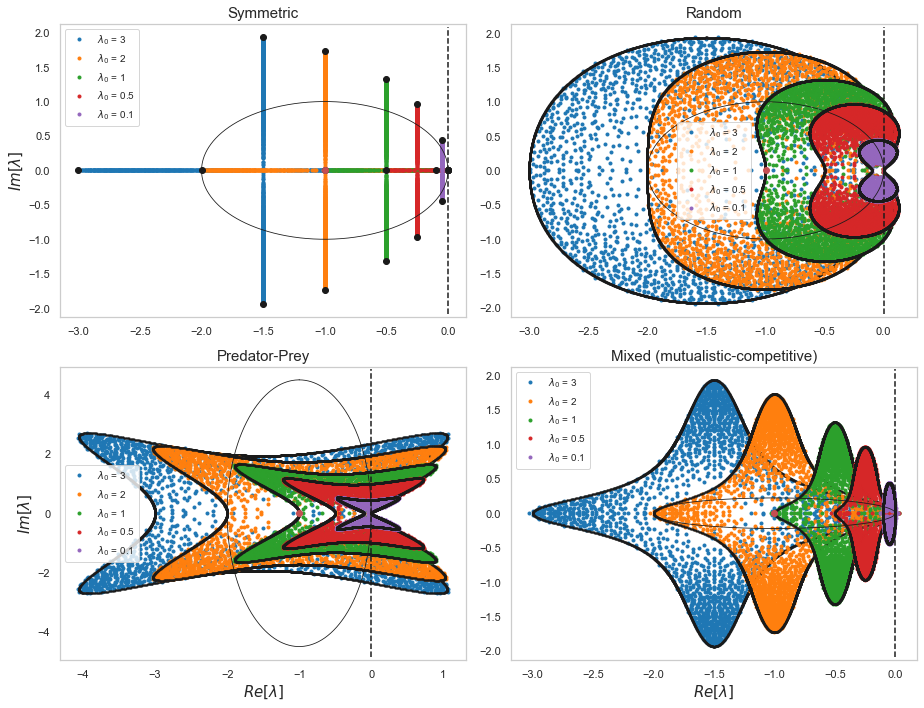

In [24]:
Class.d = 1
lamb = [3,2,1,0.5,0.1]
num=0

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(13,10)

plt.subplot(2,2,1)
Class.sigma = sigma/np.sqrt(2)
Class.sym_matrix()
for j,ll in enumerate(lamb):
    evl1, evl2  = comp_eig_delay(0,Class.M,ll)
    plt.plot(evl1.real, evl1.imag,'.',color=color[j],label=f'$\lambda_0$ = {ll}')
    plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    for k in range(num):
        Class.sym_matrix()
        evl1, evl2  = comp_eig_delay(0,Class.M,ll)
        plt.plot(evl1.real, evl1.imag,'.',color=color[j])
        plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    f1, f2 = poly_funct (0,np.array([-Class.d-complexity,-Class.d+complexity],dtype=complex),ll)
    plt.plot(f1.real,f1.imag,'ko')
    plt.plot(f2.real,f2.imag,'ko')
plt.plot(-Class.d,0,'or')
plt.plot(x-Class.d,y,'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Symmetric",fontsize=15)
plt.legend(fontsize=10)

plt.subplot(2,2,2)
Class.sigma = sigma
Class.ran_matrix()
for j,ll in enumerate(lamb):
    evl1, evl2  = comp_eig_delay(0,Class.M,ll)
    plt.plot(evl1.real, evl1.imag,'.',color=color[j],label=f'$\lambda_0$ = {ll}')
    plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    for k in range(num):
        Class.ran_matrix()
        evl1, evl2  = comp_eig_delay(0,Class.M,ll)
        plt.plot(evl1.real, evl1.imag,'.',color=color[j])
        plt.plot(evl2.real, evl2.imag,'.',color=color[j])  
    f1, f2 = poly_funct (0,x-Class.d+1.j*y,ll)
    plt.plot(f1.real,f1.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
    plt.plot(f2.real,f2.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
plt.plot(-Class.d,0,'or')
plt.plot(x-Class.d,y,'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random",fontsize=15)
plt.legend(fontsize=10)

plt.subplot(2,2,3)
Class.sigma = sigma*(np.pi/(np.pi-2))
Class.pp_matrix()
for j,ll in enumerate(lamb):
    evl1, evl2  = comp_eig_delay(0,Class.M,ll)
    plt.plot(evl1.real, evl1.imag,'.',color=color[j],label=f'$\lambda_0$ = {ll}')
    plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    for k in range(num):
        Class.pp_matrix()
        evl1, evl2  = comp_eig_delay(0,Class.M,ll)
        plt.plot(evl1.real, evl1.imag,'.',color=color[j])
        plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    f1, f2 = poly_funct (0,y1*(np.pi/(np.pi-2))-Class.d+1.j*x1*(np.pi/(np.pi-2)),ll)
    plt.plot(f1.real,f1.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
    plt.plot(f2.real,f2.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
plt.plot(-Class.d,0,'or')
plt.plot(y1*(np.pi/(np.pi-2))-Class.d,x1*(np.pi/(np.pi-2)),'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Predator-Prey",fontsize=15)
plt.legend(fontsize=10)

plt.subplot(2,2,4)
Class.sigma = sigma*np.pi/(np.pi+2)
Class.mix_matrix()
for j,ll in enumerate(lamb):
    evl1, evl2  = comp_eig_delay(0,Class.M,ll)
    plt.plot(evl1.real, evl1.imag,'.',color=color[j],label=f'$\lambda_0$ = {ll}')
    plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    for k in range(num):
        Class.mix_matrix()
        evl1, evl2  = comp_eig_delay(0,Class.M,ll)
        plt.plot(evl1.real, evl1.imag,'.',color=color[j])
        plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    f1, f2 = poly_funct (0,x1*(np.pi/(np.pi+2))-Class.d+1.j*y1*(np.pi/(np.pi+2)),ll)
    plt.plot(f1.real,f1.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
    plt.plot(f2.real,f2.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
plt.plot(-Class.d,0,'or')
plt.plot(x1*(np.pi/(np.pi+2))-Class.d,y1*(np.pi/(np.pi+2)),'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.title("Mixed (mutualistic-competitive)",fontsize=15)
plt.legend(fontsize=10)

fig.tight_layout()
plt.show(fig)

### A = - Identity , B = Random matrix (d=0)

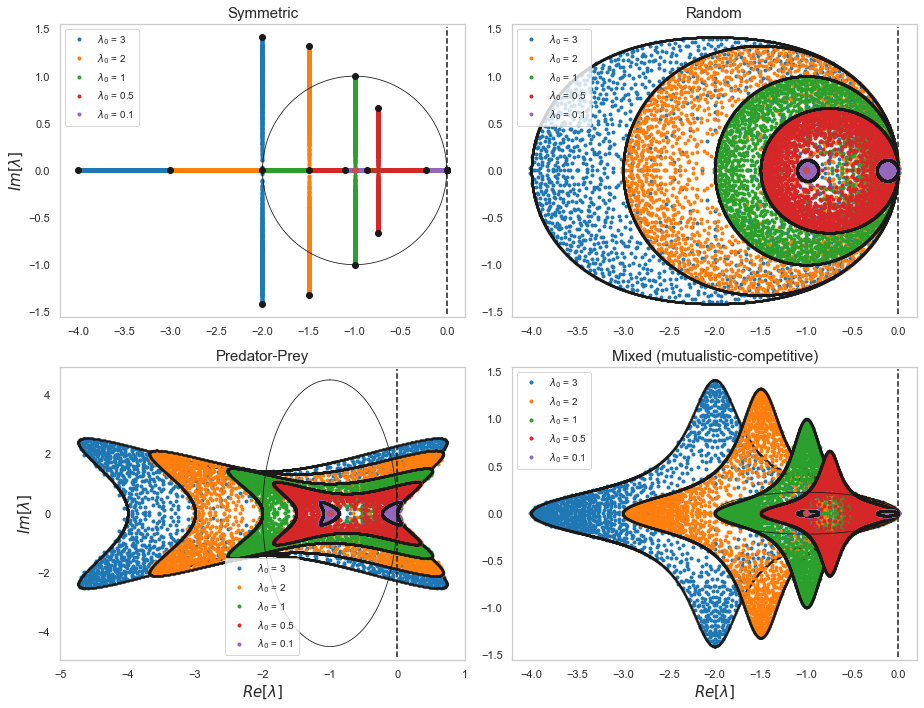

In [25]:
Class.d = 0
lamb = [3,2,1,0.5,0.1]
a = -1
num=0

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(13,10)

plt.subplot(2,2,1)
Class.sigma = sigma/np.sqrt(2)
Class.sym_matrix()
for j,ll in enumerate(lamb):
    A = a*np.eye(Class.S)
    evl1, evl2  = comp_eig_delay(A,Class.M,ll)
    plt.plot(evl1.real, evl1.imag,'.',color=color[j],label=f'$\lambda_0$ = {ll}')
    plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    for k in range(num):
        Class.sym_matrix()
        evl1, evl2  = comp_eig_delay(A,Class.M,ll)
        plt.plot(evl1.real, evl1.imag,'.',color=color[j])
        plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    f1, f2 = poly_funct (a,np.array([-Class.d-complexity,-Class.d+complexity],dtype=complex),ll)
    plt.plot(f1.real,f1.imag,'ko')
    plt.plot(f2.real,f2.imag,'ko')
plt.plot(a,0,'or')
plt.plot(x+a,y,'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Symmetric",fontsize=15)
plt.legend(fontsize=10)

plt.subplot(2,2,2)
Class.sigma = sigma
Class.ran_matrix()
for j,ll in enumerate(lamb):
    A = a*np.eye(Class.S)
    evl1, evl2  = comp_eig_delay(A,Class.M,ll)
    plt.plot(evl1.real, evl1.imag,'.',color=color[j],label=f'$\lambda_0$ = {ll}')
    plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    for k in range(num):
        Class.ran_matrix()
        evl1, evl2  = comp_eig_delay(A,Class.M,ll)
        plt.plot(evl1.real, evl1.imag,'.',color=color[j])
        plt.plot(evl2.real, evl2.imag,'.',color=color[j])  
    f1, f2 = poly_funct (a,x-Class.d+1.j*y,ll)
    plt.plot(f1.real,f1.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
    plt.plot(f2.real,f2.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
plt.plot(a,0,'or')
plt.plot(x+a,y,'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random",fontsize=15)
plt.legend(fontsize=10)

plt.subplot(2,2,3)
Class.sigma = sigma*(np.pi/(np.pi-2))
Class.pp_matrix()
for j,ll in enumerate(lamb):
    A = a*np.eye(Class.S)
    evl1, evl2  = comp_eig_delay(A,Class.M,ll)
    plt.plot(evl1.real, evl1.imag,'.',color=color[j],label=f'$\lambda_0$ = {ll}')
    plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    for k in range(num):
        Class.pp_matrix()
        evl1, evl2  = comp_eig_delay(A,Class.M,ll)
        plt.plot(evl1.real, evl1.imag,'.',color=color[j])
        plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    f1, f2 = poly_funct (a,y1*(np.pi/(np.pi-2))-Class.d+1.j*x1*(np.pi/(np.pi-2)),ll)
    plt.plot(f1.real,f1.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
    plt.plot(f2.real,f2.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
plt.plot(a,0,'or')
plt.plot(y1*(np.pi/(np.pi-2))+a,x1*(np.pi/(np.pi-2)),'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Predator-Prey",fontsize=15)
plt.legend(fontsize=10)

plt.subplot(2,2,4)
Class.sigma = sigma*np.pi/(np.pi+2)
Class.mix_matrix()
for j,ll in enumerate(lamb):
    A = a*np.eye(Class.S)
    evl1, evl2  = comp_eig_delay(A,Class.M,ll)
    plt.plot(evl1.real, evl1.imag,'.',color=color[j],label=f'$\lambda_0$ = {ll}')
    plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    for k in range(num):
        Class.mix_matrix()
        evl1, evl2  = comp_eig_delay(A,Class.M,ll)
        plt.plot(evl1.real, evl1.imag,'.',color=color[j])
        plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    f1, f2 = poly_funct (a,x1*(np.pi/(np.pi+2))-Class.d+1.j*y1*(np.pi/(np.pi+2)),ll)
    plt.plot(f1.real,f1.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
    plt.plot(f2.real,f2.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
plt.plot(a,0,'or')
plt.plot(x1*(np.pi/(np.pi+2))+a,y1*(np.pi/(np.pi+2)),'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.title("Mixed (mutualistic-competitive)",fontsize=15)
plt.legend(fontsize=10)

fig.tight_layout()
plt.show(fig)

### A = - Identity , B = Random matrix (d=1)

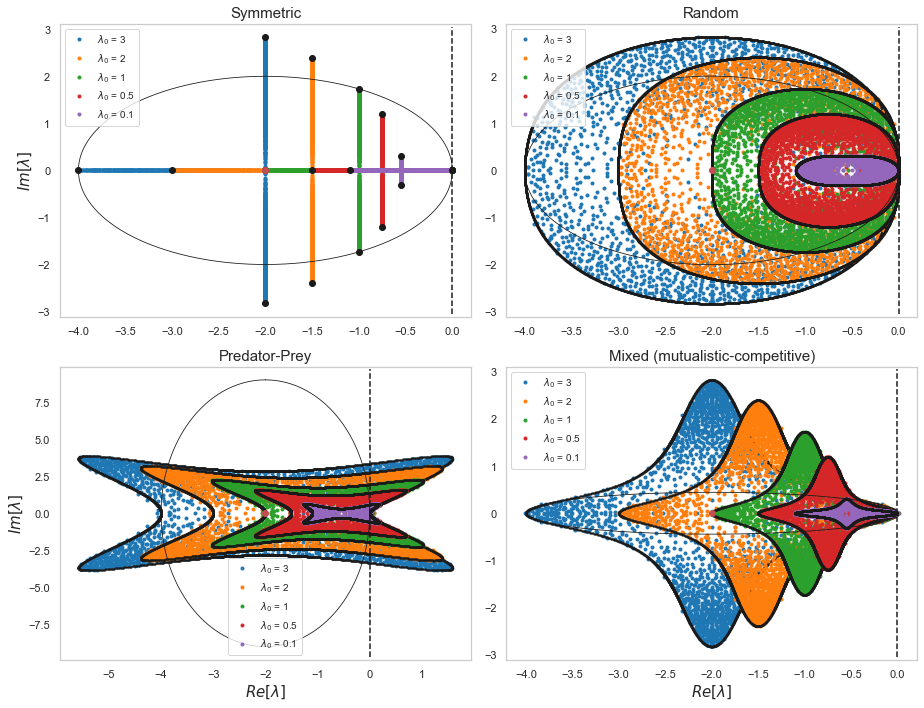

In [26]:
Class.d = 1
lamb = [3,2,1,0.5,0.1]
a = -1
num=0

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(13,10)

plt.subplot(2,2,1)
Class.sigma = 2*sigma/np.sqrt(2)
Class.sym_matrix()
for j,ll in enumerate(lamb):
    A = a*np.eye(Class.S)
    evl1, evl2  = comp_eig_delay(A,Class.M,ll)
    plt.plot(evl1.real, evl1.imag,'.',color=color[j],label=f'$\lambda_0$ = {ll}')
    plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    for k in range(num):
        Class.sym_matrix()
        evl1, evl2  = comp_eig_delay(A,Class.M,ll)
        plt.plot(evl1.real, evl1.imag,'.',color=color[j])
        plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    f1, f2 = poly_funct (a,np.array([-Class.d-2*complexity,-Class.d+2*complexity],dtype=complex),ll)
    plt.plot(f1.real,f1.imag,'ko')
    plt.plot(f2.real,f2.imag,'ko')
plt.plot(a-Class.d,0,'or')
plt.plot(2*x+a-Class.d,2*y,'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Symmetric",fontsize=15)
plt.legend(fontsize=10)

plt.subplot(2,2,2)
Class.sigma = 2*sigma
Class.ran_matrix()
for j,ll in enumerate(lamb):
    A = a*np.eye(Class.S)
    evl1, evl2  = comp_eig_delay(A,Class.M,ll)
    plt.plot(evl1.real, evl1.imag,'.',color=color[j],label=f'$\lambda_0$ = {ll}')
    plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    for k in range(num):
        Class.ran_matrix()
        evl1, evl2  = comp_eig_delay(A,Class.M,ll)
        plt.plot(evl1.real, evl1.imag,'.',color=color[j])
        plt.plot(evl2.real, evl2.imag,'.',color=color[j])  
    f1, f2 = poly_funct (a,2*x-Class.d+1.j*2*y,ll)
    plt.plot(f1.real,f1.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
    plt.plot(f2.real,f2.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
plt.plot(a-Class.d,0,'or')
plt.plot(2*x+a-Class.d,2*y,'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random",fontsize=15)
plt.legend(fontsize=10)

plt.subplot(2,2,3)
Class.sigma = 2*sigma*(np.pi/(np.pi-2))
Class.pp_matrix()
for j,ll in enumerate(lamb):
    A = a*np.eye(Class.S)
    evl1, evl2  = comp_eig_delay(A,Class.M,ll)
    plt.plot(evl1.real, evl1.imag,'.',color=color[j],label=f'$\lambda_0$ = {ll}')
    plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    for k in range(num):
        Class.pp_matrix()
        evl1, evl2  = comp_eig_delay(A,Class.M,ll)
        plt.plot(evl1.real, evl1.imag,'.',color=color[j])
        plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    f1, f2 = poly_funct (a,2*y1*(np.pi/(np.pi-2))-Class.d+1.j*2*x1*(np.pi/(np.pi-2)),ll)
    plt.plot(f1.real,f1.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
    plt.plot(f2.real,f2.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
plt.plot(a-Class.d,0,'or')
plt.plot(2*y1*(np.pi/(np.pi-2))+a-Class.d,2*x1*(np.pi/(np.pi-2)),'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Predator-Prey",fontsize=15)
plt.legend(fontsize=10)

plt.subplot(2,2,4)
Class.sigma = 2*sigma*np.pi/(np.pi+2)
Class.mix_matrix()
for j,ll in enumerate(lamb):
    A = a*np.eye(Class.S)
    evl1, evl2  = comp_eig_delay(A,Class.M,ll)
    plt.plot(evl1.real, evl1.imag,'.',color=color[j],label=f'$\lambda_0$ = {ll}')
    plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    for k in range(num):
        Class.mix_matrix()
        evl1, evl2  = comp_eig_delay(A,Class.M,ll)
        plt.plot(evl1.real, evl1.imag,'.',color=color[j])
        plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    f1, f2 = poly_funct (a,2*x1*(np.pi/(np.pi+2))-Class.d+1.j*2*y1*(np.pi/(np.pi+2)),ll)
    plt.plot(f1.real,f1.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
    plt.plot(f2.real,f2.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
plt.plot(a-Class.d,0,'or')
plt.plot(2*x1*(np.pi/(np.pi+2))+a-Class.d,2*y1*(np.pi/(np.pi+2)),'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.title("Mixed (mutualistic-competitive)",fontsize=15)
plt.legend(fontsize=10)

fig.tight_layout()
plt.show(fig)

### A = Random matrix (d=0) , B = - Identity

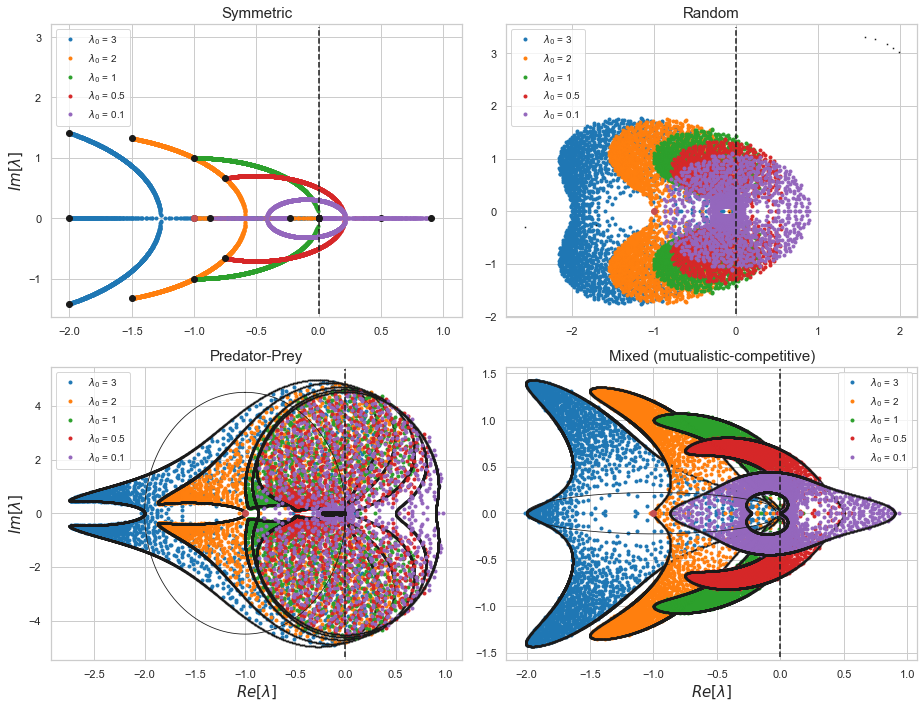

In [29]:
Class.d = 0
lamb = [3,2,1,0.5,0.1]
a = -1
num=0

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(13,10)

plt.subplot(2,2,1)
Class.sigma = sigma/np.sqrt(2)
Class.sym_matrix()
for j,ll in enumerate(lamb):
    A = a*np.eye(Class.S)
    evl1, evl2  = comp_eig_delay(Class.M,A,ll)
    plt.plot(evl1.real, evl1.imag,'.',color=color[j],label=f'$\lambda_0$ = {ll}')
    plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    for k in range(num):
        Class.sym_matrix()
        evl1, evl2  = comp_eig_delay(Class.M,A,ll)
        plt.plot(evl1.real, evl1.imag,'.',color=color[j])
        plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    f1, f2 = poly_funct (np.array([-Class.d-complexity,-Class.d+complexity],dtype=complex),a,ll)
    plt.plot(f1.real,f1.imag,'ko')
    plt.plot(f2.real,f2.imag,'ko')
plt.plot(a,0,'or')
plt.plot(x+a,y,'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Symmetric",fontsize=15)
plt.legend(fontsize=10)

plt.subplot(2,2,2)
Class.sigma = sigma
Class.ran_matrix()
for j,ll in enumerate(lamb):
    A = a*np.eye(Class.S)
    evl1, evl2  = comp_eig_delay(Class.M,A,ll)
    plt.plot(evl1.real, evl1.imag,'.',color=color[j],label=f'$\lambda_0$ = {ll}')
    plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    for k in range(num):
        Class.ran_matrix()
        evl1, evl2  = comp_eig_delay(Class.M,A,ll)
        plt.plot(evl1.real, evl1.imag,'.',color=color[j])
        plt.plot(evl2.real, evl2.imag,'.',color=color[j])  
    f1, f2 = poly_funct (x-Class.d+1.j*y,a,ll)
    plt.plot(f1.real,f1.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
    plt.plot(f2.real,f2.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
plt.plot(a,0,'or')
plt.plot(x+a,y,'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random",fontsize=15)
plt.legend(fontsize=10)

plt.subplot(2,2,3)
Class.sigma = sigma*(np.pi/(np.pi-2))
Class.pp_matrix()
for j,ll in enumerate(lamb):
    A = a*np.eye(Class.S)
    evl1, evl2  = comp_eig_delay(Class.M,A,ll)
    plt.plot(evl1.real, evl1.imag,'.',color=color[j],label=f'$\lambda_0$ = {ll}')
    plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    for k in range(num):
        Class.pp_matrix()
        evl1, evl2  = comp_eig_delay(Class.M,A,ll)
        plt.plot(evl1.real, evl1.imag,'.',color=color[j])
        plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    f1, f2 = poly_funct (y1*(np.pi/(np.pi-2))-Class.d+1.j*x1*(np.pi/(np.pi-2)),a,ll)
    plt.plot(f1.real,f1.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
    plt.plot(f2.real,f2.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
plt.plot(a,0,'or')
plt.plot(y1*(np.pi/(np.pi-2))+a,x1*(np.pi/(np.pi-2)),'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Predator-Prey",fontsize=15)
plt.legend(fontsize=10)

plt.subplot(2,2,4)
Class.sigma = sigma*np.pi/(np.pi+2)
Class.mix_matrix()
for j,ll in enumerate(lamb):
    A = a*np.eye(Class.S)
    evl1, evl2  = comp_eig_delay(Class.M,A,ll)
    plt.plot(evl1.real, evl1.imag,'.',color=color[j],label=f'$\lambda_0$ = {ll}')
    plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    for k in range(num):
        Class.mix_matrix()
        evl1, evl2  = comp_eig_delay(Class.M,A,ll)
        plt.plot(evl1.real, evl1.imag,'.',color=color[j])
        plt.plot(evl2.real, evl2.imag,'.',color=color[j])
    f1, f2 = poly_funct (x1*(np.pi/(np.pi+2))-Class.d+1.j*y1*(np.pi/(np.pi+2)),a,ll)
    plt.plot(f1.real,f1.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
    plt.plot(f2.real,f2.imag,marker='s', markersize=1.5*72./fig.dpi, mec="None", ls="None",color='k')
plt.plot(a,0,'or')
plt.plot(x1*(np.pi/(np.pi+2))+a,y1*(np.pi/(np.pi+2)),'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.title("Mixed (mutualistic-competitive)",fontsize=15)
plt.legend(fontsize=10)

fig.tight_layout()
plt.show(fig)

# Maximal eigenvalue

## Stability

In [35]:
from matplotlib.colors import LogNorm

In [37]:
lamb = 10**np.linspace(np.log10(0.01),np.log10(10.01),101)#np.linspace(0.0001,5,101)
t_max = max(lamb) + np.zeros((400,400,2))
b1_vals = np.linspace(-4,2,400)
b_vals = np.linspace(-3,3,400)

for i,x in enumerate(b1_vals):
    for j,y in enumerate(b_vals):
        evlB = x + 1.j*y
        f1,f2 = poly_funct (0,evlB,lamb)
        ind1 = f1.real <= 0
        ind2 = f2.real <= 0
        t1, t2 = lamb[ind1], lamb[ind2]
        if t1.size != 0 and t2.size != 0 :
            t_max[i,j,0] = max(min(t1),min(t2))

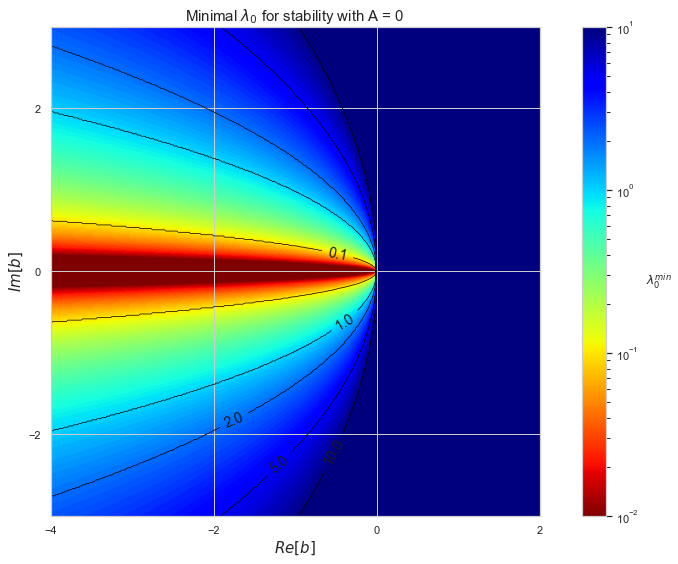

In [39]:
fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(12,8)

plt.imshow(t_max[:,:,0].T, extent=[b1_vals[0], b1_vals[-1], b_vals[0],b_vals[-1]],
           norm=LogNorm(vmin=lamb[0], vmax=lamb[-1]), origin='lower',cmap='jet_r')
#plt.contourf(b1_vals, b_vals, t_max[:,:,0].T, 20, cmap='jet_r')
clb = plt.colorbar()
clb.ax.set_ylabel(r'$\lambda_0^{min}$',rotation=0,labelpad=20)
contours = plt.contour(b1_vals, b_vals, t_max[:,:,0].T, [0.1,1,2,5,10],linewidths=0.7,colors='black')
plt.clabel(contours, inline=True, fmt='%1.1f', colors='k', fontsize=14)
plt.locator_params(nbins=5)
plt.xlabel(f'$Re[b]$',fontsize=15)
plt.ylabel(f'$Im[b]$',fontsize=15)
plt.title(r"Minimal $\lambda_0$ for stability with A = 0",fontsize=15)
#plt.grid()

fig.tight_layout()
plt.show(fig)

In [41]:
lamb = 10**np.linspace(np.log10(0.001),np.log10(10.001),101)
t_max = max(lamb) + np.zeros((400,400,2))
b1_vals = np.linspace(-3,3,400)
b_vals = np.linspace(-3,3,400)

for i,x in enumerate(b1_vals):
    for j,y in enumerate(b_vals):
        evlB = x + 1.j*y
        f1,f2 = poly_funct (-1,evlB,lamb)
        ind1 = f1.real <= 0
        ind2 = f2.real <= 0
        t1, t2 = lamb[ind1], lamb[ind2]
        if t1.size != 0 and t2.size != 0 :
            t_max[i,j,0] = max(min(t1),min(t2))

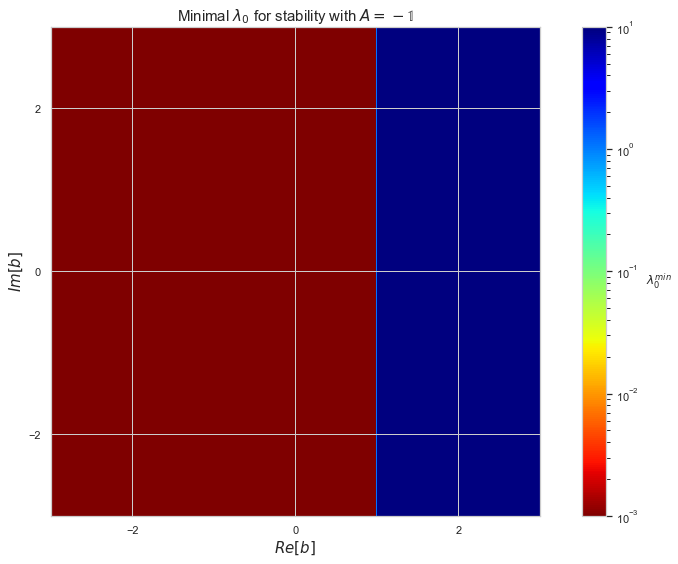

In [44]:
fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(12,8)

plt.imshow(t_max[:,:,0].T, extent=[b1_vals[0], b1_vals[-1], b_vals[0],b_vals[-1]],
           norm=LogNorm(vmin=lamb[0], vmax=lamb[-1]), origin='lower',cmap='jet_r')
#plt.contourf(b1_vals, b_vals, t_max[:,:,0].T, 20, cmap='jet_r')
clb = plt.colorbar()
clb.ax.set_ylabel(r'$\lambda_0^{min}$',rotation=0,labelpad=20)
#contours = plt.contour(b1_vals, b_vals, t_max[:,:,0].T, [0.1,1,2,5,10],linewidths=0.7,colors='black')
#plt.clabel(contours, inline=True, fmt='%1.1f', colors='k', fontsize=14)
plt.locator_params(nbins=5)
plt.xlabel(f'$Re[b]$',fontsize=15)
plt.ylabel(f'$Im[b]$',fontsize=15)
plt.title(r"Minimal $\lambda_0$ for stability with $A = -\mathbb{1}$",fontsize=15)
#plt.grid()

fig.tight_layout()
plt.show(fig)

### A = 0 , B = R.M. (d=-1)

In [45]:
S = 1000       #species - shape matrix
C = 0.4        #connectance
d = 1          #diagonal elements
mu = 0         #mean random coefficients
sigma = 0.05    #sigma random coefficients

complexity = sigma*np.sqrt(S*C)
Class = RMG(S,C,d,mu,sigma)

In [47]:
Iterations = 100
I = np.vectorize(int)
lamb = [0.1,0.5,1,2,3,10]
Svec = I(10**np.linspace(np.log10(20.1),np.log10(2000),151))
funct = ['sym','ran','pp','mix']
sig = [1/np.sqrt(2),1,np.pi/(np.pi-2),np.pi/(np.pi+2)]
data = np.zeros((len(Svec),len(lamb),4,Iterations)) #Here the maximal number of delays accepted is ten

for s,elem in enumerate(funct):
    Class.sigma = sigma*sig[s]
    print(s)
    for i,S in enumerate(Svec):
        Class.S = S
        for tt in range(Iterations):
            evlB = Class.generate_eigenvalues(mat=elem).astype(complex)
            for j,ll in enumerate(lamb): 
                evl1,evl2  = poly_funct (0,evlB,ll)
                data[i,j,s,tt] = max(np.amax(evl1.real),np.amax(evl2.real))
Std  = np.std(data,axis=3)
EE = np.mean(data,axis=3)

0
1
2
3


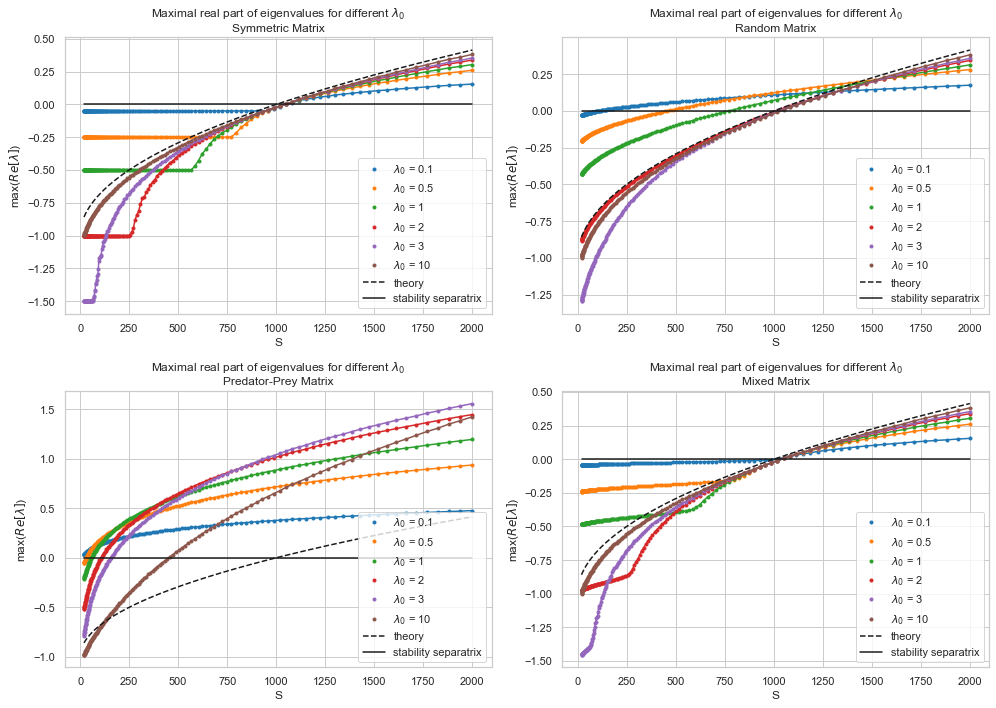

In [48]:
fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(14,10)

Type = ['Symmetric Matrix','Random Matrix','Predator-Prey Matrix','Mixed Matrix']
for s in range(4):
    plt.subplot(2,2,s+1)
    for j,ll in enumerate(lamb):
        plt.plot(Svec,EE[:,j,s],'-',color=color[j]) 
        plt.plot(Svec,EE[:,j,s],'.',color=color[j],label=f'$\lambda_0$ = {ll}')    
    plt.plot(Svec,sigma*np.sqrt(Svec*C)-1,'k--',label='theory')
    plt.plot(Svec,np.zeros(len(Svec)),'k-',label='stability separatrix')
    
    plt.xlabel('S',fontsize=12)
    plt.ylabel('max($Re[\lambda]$)',fontsize=12)
    plt.title(f"Maximal real part of eigenvalues for different $\lambda_0$\n"+Type[s])
    plt.legend()

fig.tight_layout()
plt.show(fig)

In [49]:
Iterations = 100
I = np.vectorize(int)
lamb = 10**np.linspace(np.log10(0.01),np.log10(100),201)
Svec = [500,800,1000,1200,1500]
funct = ['sym','ran','pp','mix']
sig = [1/np.sqrt(2),1,np.pi/(np.pi-2),np.pi/(np.pi+2)]
data = np.zeros((len(Svec),len(lamb),4,Iterations)) #Here the maximal number of delays accepted is ten

for s,elem in enumerate(funct):
    Class.sigma = sigma*sig[s]
    print(s)
    for i,S in enumerate(Svec):
        Class.S = S
        for tt in range(Iterations):
            evlB = Class.generate_eigenvalues(mat=elem).astype(complex)
            for j,ll in enumerate(lamb):
                evl1,evl2  = poly_funct (0,evlB,ll)
                data[i,j,s,tt] = max(np.amax(evl1.real),np.amax(evl2.real))
Std  = np.std(data,axis=3)
EE = np.mean(data,axis=3)

0
1
2
3


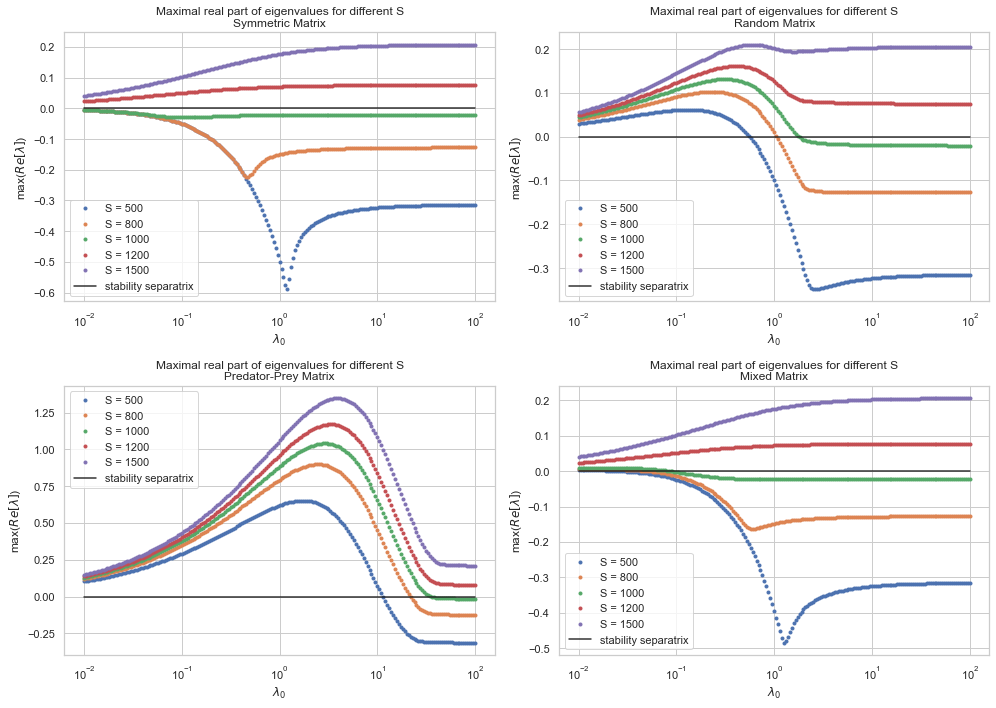

In [50]:
fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(14,10)

Type = ['Symmetric Matrix','Random Matrix','Predator-Prey Matrix','Mixed Matrix']
for s in range(4):
    plt.subplot(2,2,s+1)
    for j,S in enumerate(Svec):
        plt.plot(lamb,EE[j,:,s],'.',label=f'S = {S}')        
        #plt.plot(sigma*np.sqrt(S*C)-Class.d,'k.')
    plt.plot(lamb,np.zeros(len(lamb)),'k-',label='stability separatrix',alpha=0.9)
    
    plt.xscale('log')
    plt.xlabel(r'$\lambda_0$',fontsize=12)
    plt.ylabel('max($Re[\lambda]$)',fontsize=12)
    plt.title("Maximal real part of eigenvalues for different S\n"+Type[s])
    plt.legend()

fig.tight_layout()
plt.show(fig)

### A = -I , B = R.M. (d=0)

In [51]:
Class.d = 0
a = -1

Iterations = 100
I = np.vectorize(int)
lamb = [0.1,0.5,1,2,3,10]
Svec = I(10**np.linspace(np.log10(20.1),np.log10(2000),151))
funct = ['sym','ran','pp','mix']
sig = [1/np.sqrt(2),1,np.pi/(np.pi-2),np.pi/(np.pi+2)]
data = np.zeros((len(Svec),len(lamb),4,Iterations)) #Here the maximal number of delays accepted is ten

for s,elem in enumerate(funct):
    Class.sigma = sigma*sig[s]
    print(s)
    for i,S in enumerate(Svec):
        Class.S = S
        for tt in range(Iterations):
            evlB = Class.generate_eigenvalues(mat=elem).astype(complex)
            for j,ll in enumerate(lamb): 
                evl1,evl2  = poly_funct (a,evlB,ll)
                data[i,j,s,tt] = max(np.amax(evl1.real),np.amax(evl2.real))
Std  = np.std(data,axis=3)
EE = np.mean(data,axis=3)

0
1
2
3


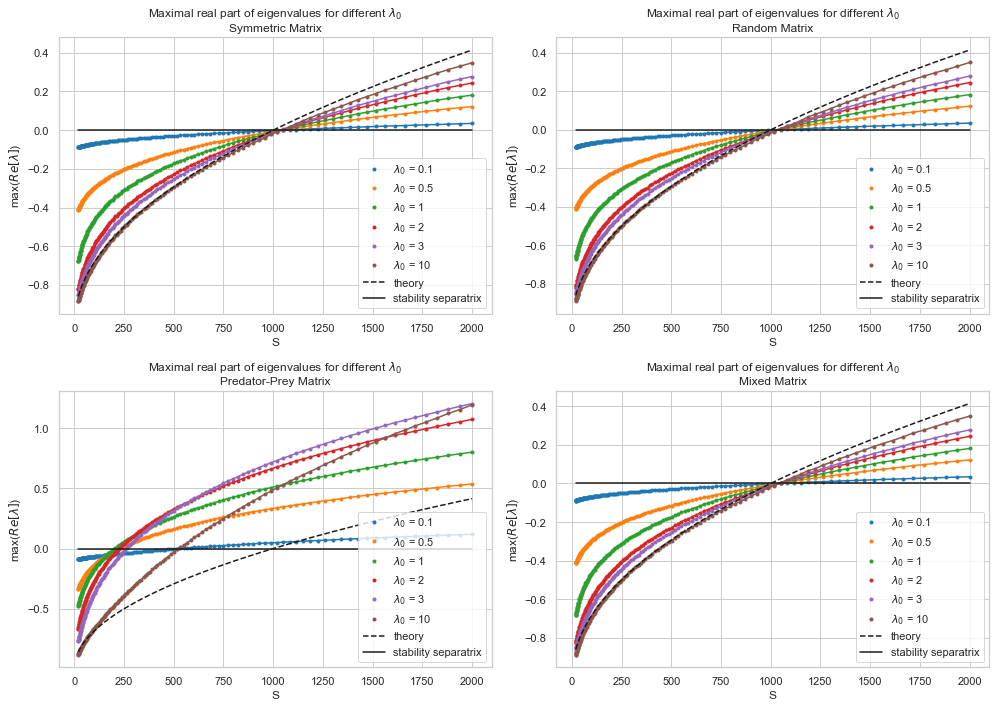

In [52]:
fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(14,10)

Type = ['Symmetric Matrix','Random Matrix','Predator-Prey Matrix','Mixed Matrix']
for s in range(4):
    plt.subplot(2,2,s+1)
    for j,ll in enumerate(lamb):
        plt.plot(Svec,EE[:,j,s],'-',color=color[j]) 
        plt.plot(Svec,EE[:,j,s],'.',color=color[j],label=f'$\lambda_0$ = {ll}')    
    plt.plot(Svec,sigma*np.sqrt(Svec*C)-1,'k--',label='theory')
    plt.plot(Svec,np.zeros(len(Svec)),'k-',label='stability separatrix')
    
    plt.xlabel('S',fontsize=12)
    plt.ylabel('max($Re[\lambda]$)',fontsize=12)
    plt.title(r'Maximal real part of eigenvalues for different $\lambda_0$'+"\n"+Type[s])
    plt.legend()

fig.tight_layout()
plt.show(fig)

In [53]:
Iterations = 100
I = np.vectorize(int)
lamb = 10**np.linspace(np.log10(0.01),np.log10(100),201)
Svec = [500,800,1000,1200,1500]
funct = ['sym','ran','pp','mix']
sig = [1/np.sqrt(2),1,np.pi/(np.pi-2),np.pi/(np.pi+2)]
data = np.zeros((len(Svec),len(lamb),4,Iterations)) #Here the maximal number of delays accepted is ten

for s,elem in enumerate(funct):
    Class.sigma = sigma*sig[s]
    print(s)
    for i,S in enumerate(Svec):
        Class.S = S
        for tt in range(Iterations):
            evlB = Class.generate_eigenvalues(mat=elem).astype(complex)
            for j,ll in enumerate(lamb):
                evl1,evl2  = poly_funct (a,evlB,ll)
                data[i,j,s,tt] = max(np.amax(evl1.real),np.amax(evl2.real))
Std  = np.std(data,axis=3)
EE = np.mean(data,axis=3)

0
1
2
3


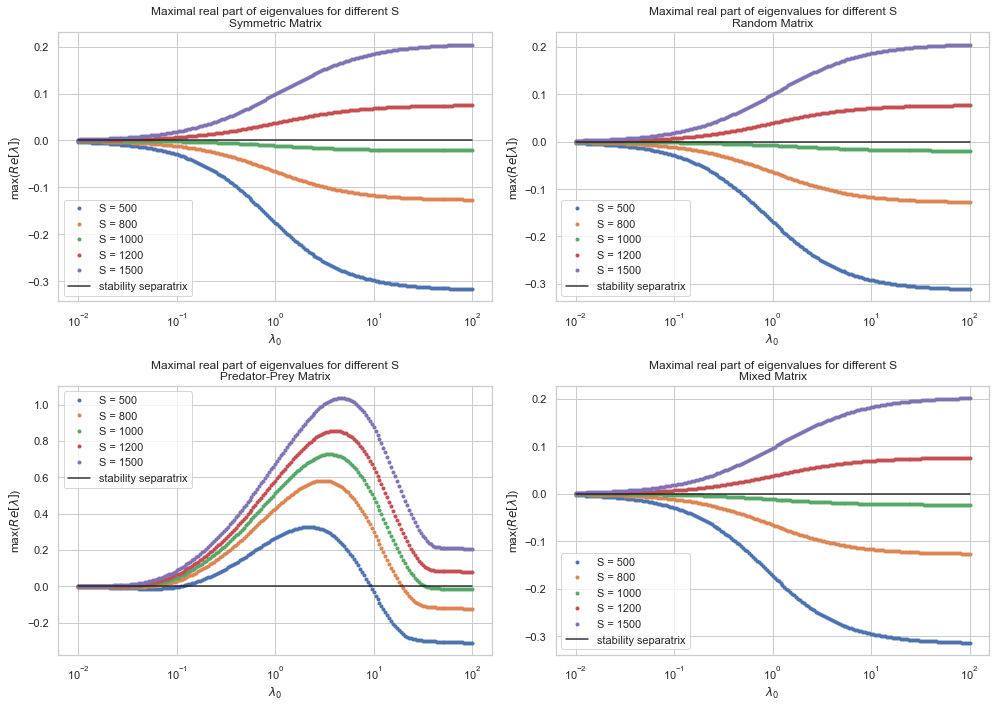

In [54]:
fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(14,10)

Type = ['Symmetric Matrix','Random Matrix','Predator-Prey Matrix','Mixed Matrix']
for s in range(4):
    plt.subplot(2,2,s+1)
    for j,S in enumerate(Svec):
        plt.plot(lamb,EE[j,:,s],'.',label=f'S = {S}')        
        #plt.plot(sigma*np.sqrt(S*C)-Class.d,'k.')
    plt.plot(lamb,np.zeros(len(lamb)),'k-',label='stability separatrix',alpha=0.9)
    
    plt.xscale('log')
    plt.xlabel(r'$\lambda_0$',fontsize=12)
    plt.ylabel('max($Re[\lambda]$)',fontsize=12)
    plt.title("Maximal real part of eigenvalues for different S\n"+Type[s])
    plt.legend()

fig.tight_layout()
plt.show(fig)